<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/link_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Graph Link Prediction

* The main idea is to train a model using graph featurs to predict which nodes will connect together, which will not.
  * It has to use labelled data from a graph
  * Using some unlinked nodes to form negative labels
  * Remove some linked nodes to form positive labels
  * Then generate graph features with advanced models such as node2vec, to train the model
  * But the assumption here is, the unlinked nodes used to generate features won't link together...

* Download the data from http://networkrepository.com/fb-pages-food.php

In [ ]:
# install node2vec
!pip install node2vec

In [2]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

print(len(fb_nodes), len(fb_links))

621 2102


In [8]:
fb_nodes[0:4]

['id,name,new_id',
 '402449106435352,Josh Marks,386',
 '368969274888,Blue Ribbon Restaurants,473',
 '765596333518863,Pat Neely,1']

In [9]:
fb_links[0:4]  # linked node ids

['0,276', '0,58', '0,132', '0,603']

In [11]:
node_list_1 = []
node_list_2 = []

for i in fb_links:
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

link_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})
link_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


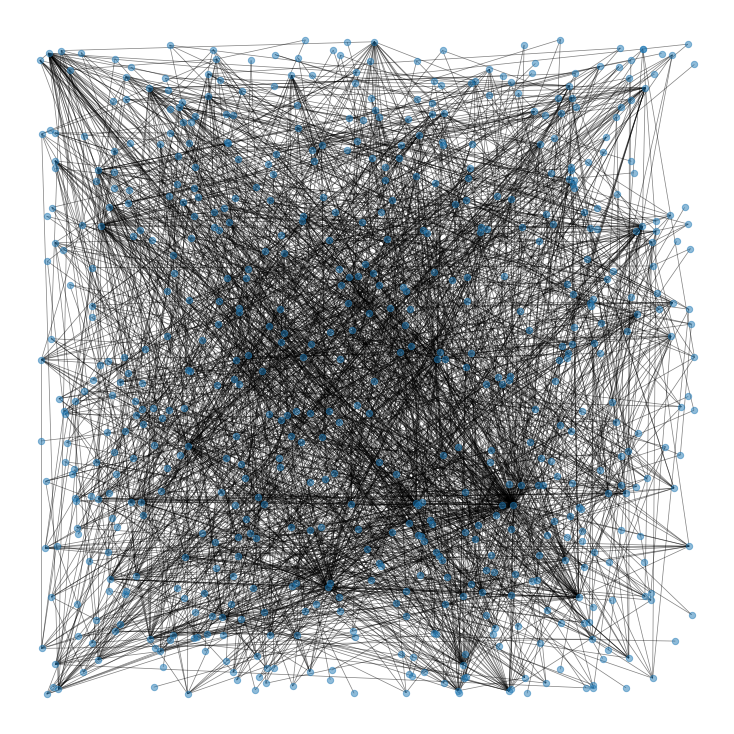

In [13]:
# Create the graph based on the linked nodes
G = nx.from_pandas_edgelist(link_df, "node_1", "node_2",
                            create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=10)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, 
        alpha = 0.5, width = 0.7)

plt.show()

## Create Negative & Positive Labels

* Negative labels are links of some unconnected nodes
  * Choose those nodes with shortest path length <= 2
* Positive labels are removed links of some connected nodes
  * When removing the links, make sure there is still 1 graph only
  * Also make sure the number of nodes in the updated graph is the same as the original nodes count

### Create Negative Labels

In [21]:
# Create adjacency matrix
node_set = list(set(node_list_1 + node_list_2))
print(len(node_set))
node_set[0:10]

620


['114', '539', '424', '149', '537', '355', '575', '35', '471', '210']

In [23]:
adj_matrix = nx.to_numpy_matrix(G, nodelist = node_set)
print(adj_matrix.shape)
adj_matrix

(620, 620)


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
unconnected_node_lst1, unconnected_node_lst2 = [], []

for i in tqdm(range(adj_matrix.shape[0])):
  for j in range(i+1, adj_matrix.shape[1]):
    # I'm not sure why there are unconnected nodes with shortest path length as 1
    if nx.shortest_path_length(G, str(i), str(j)) <=2 and adj_matrix[i,j] == 0:
      unconnected_node_lst1.append(node_list[i])
      unconnected_node_lst2.append(node_list[j])

print(len(unconnected_node_lst1), len(unconnected_node_lst2))

100%|██████████| 620/620 [00:11<00:00, 55.27it/s] 

19019 19019


In [30]:
neg_df = pd.DataFrame({'node_1': unconnected_node_lst1, 
                       'node_2': unconnected_node_lst2,
                       'label':0})
print(neg_df.shape)
neg_df.head()

(19019, 3)


,node_1,node_2,label
0,114,293,0
1,114,190,0
2,114,86,0
3,114,454,0
4,114,615,0


### Create Positive Labels

In [32]:
link_df_copy = link_df.copy()
initial_node_count = len(G.nodes)

removable_links_idx = []

for idx in tqdm(link_df.index.values):
  tmp_G = nx.from_pandas_edgelist(link_df_copy.drop(index=idx), 
                                  "node_1", "node_2",
                            create_using=nx.Graph())
  if nx.number_connected_components(tmp_G) == 1 and len(tmp_G) == initial_node_count:
    removable_links_idx.append(idx)
    link_df_copy = link_df_copy.drop(index=idx)

print(len(removable_links_idx))

100%|██████████| 2102/2102 [00:09<00:00, 211.52it/s]

1483


In [33]:
pos_df = link_df.loc[removable_links_idx]
pos_df['label'] = 1
print(pos_df.shape)

pos_df.head()

(1483, 3)


,node_1,node_2,label
0,0,276,1
1,0,58,1
2,0,132,1
3,0,603,1
4,0,398,1


In [34]:
label_df = neg_df.append(pos_df, ignore_index=True)
print(label_df.shape)
print(label_df['label'].value_counts())
label_df.head()

(20502, 3)
0    19019
1     1483
Name: label, dtype: int64


,node_1,node_2,label
0,114,293,0
1,114,190,0
2,114,86,0
3,114,454,0
4,114,615,0


### Extract graph features using node2vec
* Need to remove the selected positive links before extracting the features

In [54]:
print(link_df.shape)
link_df = link_df.drop(index=removable_links_idx)
print(len(removable_links_idx), link_df.shape)

(2102, 2)
1483 (619, 2)


In [57]:
updated_G = nx.from_pandas_edgelist(link_df, "node_1", "node_2", create_using=nx.Graph())
print(len(updated_G))

620


In [58]:
from node2vec import Node2Vec

node2vec = Node2Vec(updated_G, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


In [64]:
# with the trained node2vec model, we can get the featues for selected links

# X = [n2w_model[str(i)]+n2w_model[str(j)] for i,j in zip(label_df['node_1'], label_df['node_2'])]
len(X)

20502

In [66]:
print(len(X[0]))  # as specified to have 100 dimensions
X[0]

100


array([ 2.0412841e+00, -1.0070086e+00,  2.1091008e-01, -2.9756150e+00,
       -8.4656018e-01,  3.2414138e-01,  3.7746394e-01,  7.4874765e-01,
       -1.0872661e+00, -8.9152539e-01, -2.1268547e+00,  4.6290118e-01,
        1.6893370e+00, -9.5447254e-01,  1.6106017e+00,  8.8970941e-01,
       -8.3733755e-01, -2.2297093e-01,  1.9448402e+00,  9.5192552e-02,
       -1.7721910e+00,  1.0345402e-01, -3.7238625e-01, -9.4118309e-01,
        1.3375096e-01, -1.1540539e+00, -4.2083150e-01, -7.1347773e-02,
        7.6097512e-01,  9.7727138e-01,  1.2757175e+00, -1.1105241e+00,
        9.5664334e-01, -5.9952009e-01,  2.4297547e-01, -1.8545737e+00,
        1.9163675e+00,  5.6887382e-01,  1.1054723e+00, -1.6229186e+00,
        6.7309439e-01,  3.0899119e+00,  2.1872419e-01,  6.4046639e-01,
       -1.9942365e+00, -6.3747472e-01, -9.1327506e-01, -6.3963205e-02,
       -1.2523851e+00, -1.4721784e-01,  4.4790727e-01, -3.6383542e-01,
       -2.0554061e+00, -1.4307365e+00,  2.1962798e+00, -2.1575215e-01,
      

In [67]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), label_df['label'], 
                                                test_size = 0.3, 
                                                random_state = 10)

In [69]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14351, 100) (6151, 100) (14351,) (6151,)


### Train the model

In [70]:
import lightgbm as lgbm

In [75]:
train_data = lgbm.Dataset(X_train, y_train)
test_data = lgbm.Dataset(X_test, y_test)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': ['auc'],
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 10
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[1]	valid_0's auc: 0.728171
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.785237
[3]	valid_0's auc: 0.799458
[4]	valid_0's auc: 0.814411
[5]	valid_0's auc: 0.821518
[6]	valid_0's auc: 0.830292
[7]	valid_0's auc: 0.836006
[8]	valid_0's auc: 0.840245
[9]	valid_0's auc: 0.843212
[10]	valid_0's auc: 0.846444
[11]	valid_0's auc: 0.850624
[12]	valid_0's auc: 0.853719
[13]	valid_0's auc: 0.856585
[14]	valid_0's auc: 0.859067
[15]	valid_0's auc: 0.861129
[16]	valid_0's auc: 0.863433
[17]	valid_0's auc: 0.864047
[18]	valid_0's auc: 0.864148
[19]	valid_0's auc: 0.865658
[20]	valid_0's auc: 0.867429
[21]	valid_0's auc: 0.86903
[22]	valid_0's auc: 0.872676
[23]	valid_0's auc: 0.874173
[24]	valid_0's auc: 0.875907
[25]	valid_0's auc: 0.876878
[26]	valid_0's auc: 0.878899
[27]	valid_0's auc: 0.878549
[28]	valid_0's auc: 0.878767
[29]	valid_0's auc: 0.879575
[30]	valid_0's auc: 0.881023
[31]	valid_0's auc: 0.881847
[32]	valid_0's auc: 0.882248
[33]	valid_0's auc: 

In [83]:
lgbm_cv_result = lgbm.cv(parameters, train_data, num_boost_round=100, nfold=10, seed=10,
        verbose_eval=True,
        stratified=True, shuffle=True, metrics='auc')

[1]	cv_agg's auc: 0.724192 + 0.0290376
[2]	cv_agg's auc: 0.770756 + 0.0178433
[3]	cv_agg's auc: 0.790588 + 0.0170202
[4]	cv_agg's auc: 0.804218 + 0.0163184
[5]	cv_agg's auc: 0.815676 + 0.0153794
[6]	cv_agg's auc: 0.824065 + 0.0139281
[7]	cv_agg's auc: 0.83012 + 0.0138105
[8]	cv_agg's auc: 0.834716 + 0.0139542
[9]	cv_agg's auc: 0.839892 + 0.0132793
[10]	cv_agg's auc: 0.844675 + 0.0136221
[11]	cv_agg's auc: 0.848077 + 0.0138363
[12]	cv_agg's auc: 0.850842 + 0.0131304
[13]	cv_agg's auc: 0.853706 + 0.0126217
[14]	cv_agg's auc: 0.856349 + 0.0131053
[15]	cv_agg's auc: 0.859996 + 0.0125771
[16]	cv_agg's auc: 0.861891 + 0.0111038
[17]	cv_agg's auc: 0.863811 + 0.0110603
[18]	cv_agg's auc: 0.865699 + 0.0115417
[19]	cv_agg's auc: 0.866821 + 0.0118142
[20]	cv_agg's auc: 0.868735 + 0.0114463
[21]	cv_agg's auc: 0.872075 + 0.0113292
[22]	cv_agg's auc: 0.874776 + 0.0112823
[23]	cv_agg's auc: 0.876408 + 0.0114199
[24]	cv_agg's auc: 0.87867 + 0.0114371
[25]	cv_agg's auc: 0.880344 + 0.0112437
[26]	cv_agg

In [86]:
final_avg_auc = np.mean(lgbm_cv_result['auc-mean'])
final_avg_std = np.mean(lgbm_cv_result['auc-stdv'])
print(final_avg_auc, final_avg_std)

0.8906933426173002 0.013634282045563417


## Summary

* If using CV, avg AUC is 0.89
  * Without using CV, run once got 0.92, similar

* Reference: https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+AnalyticsVidhya+%28Analytics+Vidhya%29